<a href="https://colab.research.google.com/github/abrown12005/CMP_SC-4540-HW/blob/main/HW3/MicrobitLogRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic regression with a micro bit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
# Convert milligravities to m/s2
MG_TO_MS2 = 0.00980665

def process_data(data):
    # Clean the columns
    orig_columns = ["time (source1)", "x", "y", "z"]
    new_columns = ["t", "ax", "ay", "az"]
    data = data[orig_columns]
    data.columns = new_columns

    # Clean NaNs
    data = data.dropna()

    # Convert to m/s2
    for acc in ['ax', 'ay', 'az']:
        data[acc] = data[acc] * MG_TO_MS2

    # Replace outliers with the median
    for acc in ['ax', 'ay', 'az']:
        acc_raw = data[acc].copy()
        acc_raw[np.abs(acc_raw / np.median(acc_raw)) > 1.5] = np.median(acc_raw)
        data[acc] = acc_raw

    # Compute velocity
    data['vx'] = cumulative_trapezoid(data['ax'], data['t'], initial = 0)
    data['vy'] = cumulative_trapezoid(data['ay'], data['t'], initial = 0)
    data['vz'] = cumulative_trapezoid(data['az'], data['t'], initial = 0)

    # Compute position
    data['x'] = cumulative_trapezoid(data['vx'], data['t'], initial = 0)
    data['y'] = cumulative_trapezoid(data['vy'], data['t'], initial = 0)
    data['z'] = cumulative_trapezoid(data['vz'], data['t'], initial = 0)

    return data

1. Read and preprocess the dataset.

In [3]:
import io

RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    # clone github repo with the data
    !git clone https://github.com/abrown12005/CMP_SC-4540-HW.git
    %cd CMP_SC-4540-HW/HW3

data = pd.read_csv('ShakeData.csv')

# Rename the column to match what process_data expects
data = data.rename(columns={"time (seconds)": "time (source1)"})

data = process_data(data)
data.head()

Cloning into 'CMP_SC-4540-HW'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 133 (delta 35), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (133/133), 1.57 MiB | 4.99 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/CMP_SC-4540-HW/HW3


,t,ax,ay,az,vx,vy,vz,x,y,z
0,4.655,0.0,0.0,-10.032203,0.0,0.0,0.000000,0.0,0.0,0.000000
1,4.757,0.0,0.0,-10.032203,0.0,0.0,-1.023285,0.0,0.0,-0.052188
2,4.859,0.0,0.0,-10.032203,0.0,0.0,-2.046569,0.0,0.0,-0.208750
3,4.959,0.0,0.0,-10.032203,0.0,0.0,-3.049790,0.0,0.0,-0.463568
4,5.063,0.0,0.0,-10.032203,0.0,0.0,-4.093139,0.0,0.0,-0.835000


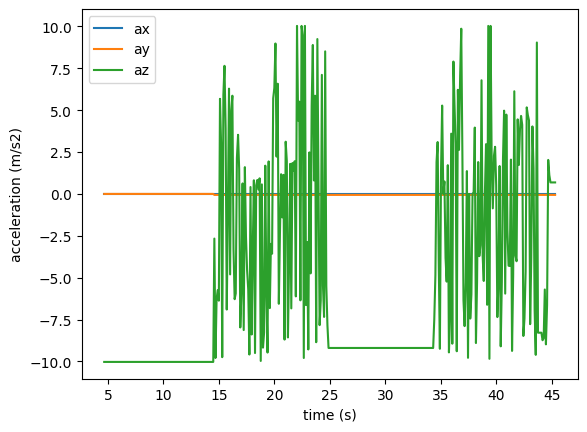

In [4]:
for acc in ['ax', 'ay', 'az']:
    plt.plot(data['t'], data[acc], label = acc)
plt.xlabel("time (s)")
plt.ylabel("acceleration (m/s2)")
plt.legend()

2. Pick a time period of clean data.

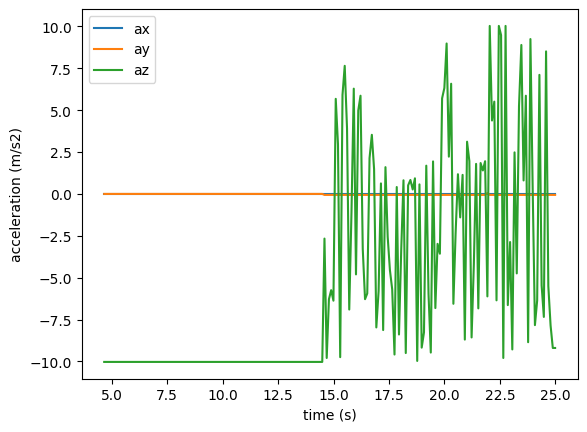

In [5]:
t_start = 0 # seconds
t_end = 25 # seconds

data = data[(data['t'] > t_start) & (data['t'] < t_end)]

for position in ['ax', 'ay', 'az']:
    plt.plot(data['t'], data[position], label = position)
plt.xlabel("time (s)")
plt.ylabel("acceleration (m/s2)")
plt.legend()

3. Split the data into train and test.

In [6]:
X_train = data.loc[data['t'] < 14, ['t', 'ax', 'ay', 'az']]
y_train = np.ones(len(X_train))
y_train[X_train['t'] < 7] = 0

X_test = data.loc[(data['t'] > 14) & (data['t'] < 24), ['t', 'ax', 'ay', 'az']]
y_test = np.ones(len(X_test))
y_test[X_test['t'] < 17] = 0

4. Train a logistic regression model
$$
\hat{p} = \sigma(b_0 + b_1 \times t + b_2 \times a_x + b_3 \times a_y + b_4 \times a_z)
$$

In [7]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [8]:
accuracy_score(y_test, preds)

0.7040816326530612

In [9]:
preds

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])